In [1]:
%matplotlib inline
import itertools
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.io import loadmat
from sklearn.mixture import BayesianGaussianMixture
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern,WhiteKernel, ConstantKernel as C
from os.path import dirname, join as pjoin
from scipy.linalg import block_diag
import warnings
warnings.filterwarnings('ignore')


color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y, means, covariances, index, title):
    splot = plt.subplot(1, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

def plot_samples(X, Y, n_components, index, title):
    plt.subplot(5, 1, 4 + index)
    for i, color in zip(range(n_components), color_iter):
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

    plt.xlim(-6., 4. * np.pi - 6.)
    plt.ylim(-5., 5.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())

In [2]:
from utils import load_lasa
def load(self, shape='DoubleBendedLine'):

    X, Y = load_lasa(shape)
    return X, Y

Using LASA DataSet from /home/oem/v_torch/lib/python3.8/site-packages/pyLasaDataset/resources/LASAHandwritingDataset/DataSet


In [3]:
def var_gradient(pos, lscale, training_pos, krnl_, K_inv):
    pos = pos.reshape(1, 2)
    k_star = krnl_(training_pos, pos).reshape(-1, 1)
    dKdx = k_star * (training_pos[:, 0].reshape(-1, 1) - pos[0][0]) / (lscale[0] ** 2)
    dKdy = k_star * (training_pos[:, 1].reshape(-1, 1) - pos[0][1]) / (lscale[1] ** 2)
    a = -2 * np.matmul(np.transpose(k_star), K_inv)
    dSigma_dx_ = np.matmul(a, np.reshape(dKdx, [len(a[0]), 1]))
    dSigma_dy_ = np.matmul(a, np.reshape(dKdy, [len(a[0]), 1]))
    return float(dSigma_dx_), float(dSigma_dy_)

def Global_Attractor(X,X_goal):
    Y=(X_goal-X)
    Y_norm=np.clip((np.sqrt(Y[0]**2+Y[1]**2)),0,1)
    #print(Y)
    if (np.sqrt(Y[0]**2+Y[1]**2))>0.0000001:
        Y=Y_norm*Y/(np.sqrt(Y[0]**2+Y[1]**2))
    else:
        Y=Y
    return Y 

In [4]:
X, X_dot= load('GShape')
# downsample the data
X = X[100::5]
X_dot = X_dot[100::5]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fe5bc5e8a60>
Traceback (most recent call last):
  File "/home/oem/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/oem/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/oem/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/oem/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Not empty components:
1
2
4
6
7
9
12
13


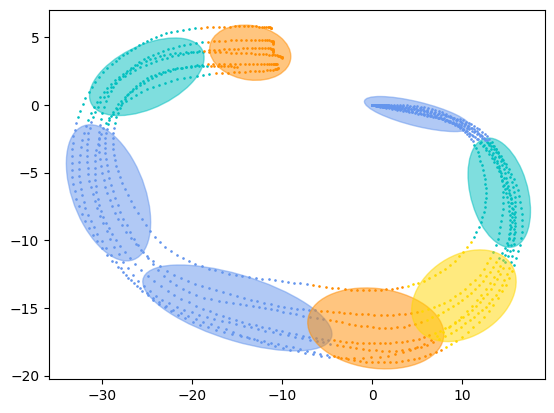

In [5]:
#create empty list for each components of the mixture
GP_=[]
IND=[]
KERNEL_PAR=[]
KERNEL=[]
KINV=[]
X_=[]

k = C(constant_value=np.sqrt(0.1))  * Matern(1*np.ones(2), nu=1.5) + WhiteKernel(0.01 )
gp = GaussianProcessRegressor(kernel=k, alpha=1e-10, n_restarts_optimizer=5)
gmm = BayesianGaussianMixture(n_components=20,weight_concentration_prior_type='dirichlet_process',weight_concentration_prior=1).fit(X)

plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, 'Expectation-maximization')

index=gmm.predict(X)
print("Not empty components:")
for i in range(gmm.n_components):
    if not np.any(index== i):
        continue
    print(i)    
    X_0=(X[index==i,:])
    
    Y_0=(X_dot[index==i,:])
    gp = GaussianProcessRegressor(kernel=k, alpha=1e-10, n_restarts_optimizer=5)
    gp.fit(X_0,Y_0)
    gp_kernels_ = gp.kernel_
    kernel_params_ = [gp_kernels_.get_params()['k1__k2__length_scale'], gp_kernels_.get_params()['k1']]
    noise_var_ = gp.alpha + gp_kernels_.get_params()['k2__noise_level']
    K_ = gp_kernels_(X_0, X_0) + (noise_var_ * np.eye(len(X_0)))
    K_inv = np.linalg.inv(K_)
    KERNEL.append(gp_kernels_)
    KINV.append(K_inv)
    KERNEL_PAR.append(kernel_params_)
    GP_.append(gp)
    X_.append(X_0)
    IND.append(i)
x=np.linspace(np.min(X[:,0]-10), np.max(X[:,0]+10), 100)
y=np.linspace(np.min(X[:,1]-10), np.max(X[:,1]+10), 100)
# Creating grids
XX, YY = np.meshgrid(x, y)
u=np.ones((len(x),len(y)))
v=np.ones((len(x),len(y)))

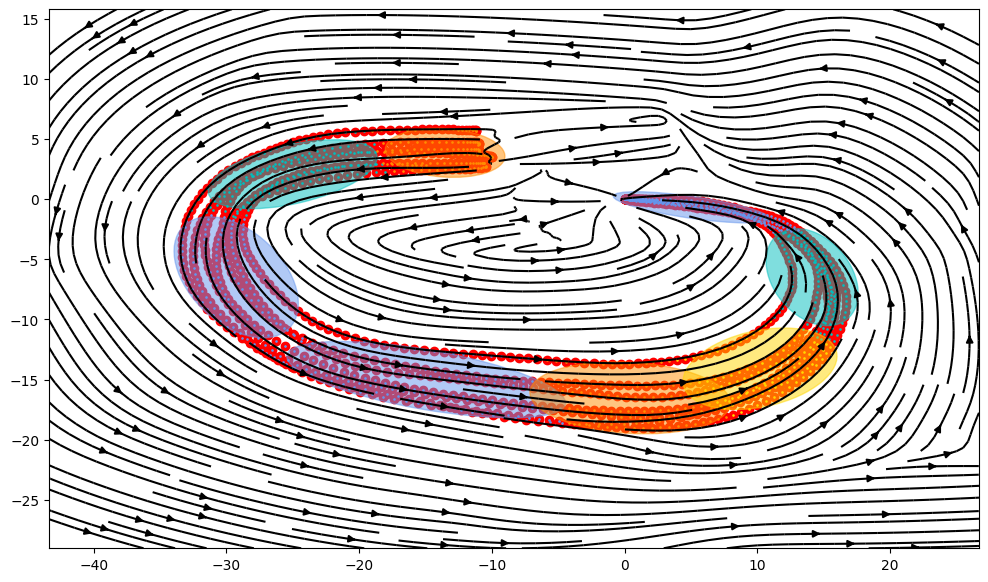

In [6]:
vel_x=np.zeros(np.shape(GP_)[0])
vel_y=np.zeros(np.shape(GP_)[0])
grad_x=np.zeros(np.shape(GP_)[0])
grad_y=np.zeros(np.shape(GP_)[0])
var_=np.zeros(np.shape(GP_)[0])
WEI=np.zeros(np.shape(GP_)[0])
x=np.linspace(np.min(X[:,0]-10), np.max(X[:,0]+10), 100)
y=np.linspace(np.min(X[:,1]-10), np.max(X[:,1]+10), 100)
# Creating grids
XX, YY = np.meshgrid(x, y)
u=np.ones((len(x),len(y)))
v=np.ones((len(x),len(y)))
for i in range(len(y)):
    for j in range(len(x)):
        pos=np.array([XX[i,j],YY[i, j]]).reshape(1,-1)
        weights=(gmm.predict_proba(pos))
        for k in range(np.shape(GP_)[0]):
            [vel, var]=GP_[k].predict(pos, return_std=True)
            grad=var_gradient(pos, KERNEL_PAR[k][0], X_[k], KERNEL[k], KINV[k] ) 
            grad_x[k]=grad[0]
            grad_y[k]=grad[1]
            vel_x[k]=vel[0][0]
            vel_y[k]=vel[0][1]
            var_[k]=var[0][0]
            WEI[k]=weights[0][IND[k]]
        WEI=WEI.reshape(np.shape(GP_)[0],1)   
        grad_x_avg=np.dot(grad_x.reshape(1,-1), WEI )
        grad_y_avg=np.dot(grad_y.reshape(1,-1), WEI)
        
        var_avg=np.dot(var_, WEI)
        vel_x_avg=np.dot(vel_x, WEI)
        vel_y_avg=np.dot(vel_y, WEI)
        u[i,j]=vel_x_avg[0]
        v[i,j]=vel_y_avg[0]        

        
fig = plt.figure(figsize = (12, 7))
plt.streamplot(XX, YY, u, v, density = 2, color=[0,0,0])
plt.scatter(X[:,0],X[:,1], color=[1,0,0])
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,'Expectation-maximization')

plt.show()

In [7]:
vel_x=np.zeros(np.shape(GP_)[0])
vel_y=np.zeros(np.shape(GP_)[0])
grad_x=np.zeros(np.shape(GP_)[0])
grad_y=np.zeros(np.shape(GP_)[0])
var_=np.zeros(np.shape(GP_)[0])
WEI=np.zeros(np.shape(GP_)[0])
x=np.linspace(np.min(X[:,0]-10), np.max(X[:,0]+10), 100)
y=np.linspace(np.min(X[:,1]-10), np.max(X[:,1]+10), 100)
# Creating grids
XX, YY = np.meshgrid(x, y)
u=np.ones((len(x),len(y)))
v=np.ones((len(x),len(y)))
for i in range(len(y)):
    for j in range(len(x)):
        pos=np.array([XX[i,j],YY[i, j]]).reshape(1,-1)
        weights=(gmm.predict_proba(pos))
        for k in range(np.shape(GP_)[0]):
            [vel, var]=GP_[k].predict(pos, return_std=True)
            grad=var_gradient(pos, KERNEL_PAR[k][0], X_[k], KERNEL[k], KINV[k] )
            grad_x[k]=grad[0]
            grad_y[k]=grad[1]
            vel_x[k]=vel[0][0]
            vel_y[k]=vel[0][1]
            var_[k]=var[0][0]
            WEI[k]=weights[0][IND[k]]
        WEI=WEI.reshape(np.shape(GP_)[0],1)   
        grad_x_avg=np.dot(grad_x.reshape(1,-1), WEI )
        grad_y_avg=np.dot(grad_y.reshape(1,-1), WEI)
        
        var_avg=np.dot(var_, WEI)
        vel_x_avg=np.dot(vel_x, WEI)
        vel_y_avg=np.dot(vel_y, WEI)
        u[i,j]=vel_x_avg[0]-var_avg[0]*(grad_x_avg/np.linalg.norm([grad_x_avg,grad_x_avg]))
        v[i,j]=vel_y_avg[0]-var_avg[0]*(grad_y_avg/np.linalg.norm([grad_x_avg,grad_x_avg]))        

        
fig = plt.figure(figsize = (12, 7))
plt.streamplot(XX, YY, u, v, density = 2, color=[0,0,0])
plt.scatter(X[:,0],X[:,1], color=[1,0,0])
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,'Expectation-maximization')

plt.show()

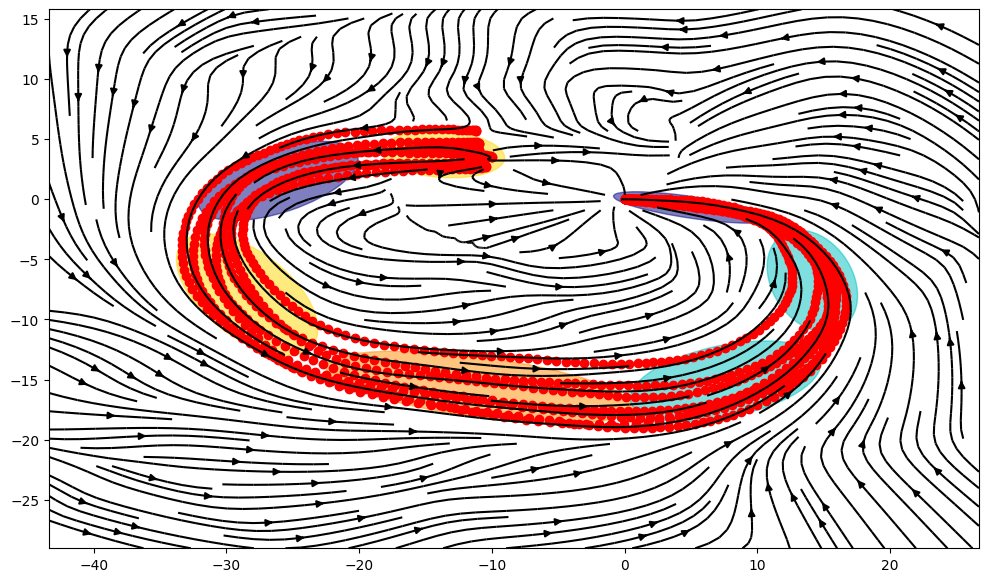

In [ ]:
X_goal=X[-1,:]
vel_x=np.zeros(np.shape(GP_)[0])
vel_y=np.zeros(np.shape(GP_)[0])
grad_x=np.zeros(np.shape(GP_)[0])
grad_y=np.zeros(np.shape(GP_)[0])
var_=np.zeros(np.shape(GP_)[0])
WEI=np.zeros(np.shape(GP_)[0])
x=np.linspace(np.min(X[:,0]-10), np.max(X[:,0]+10), 100)
y=np.linspace(np.min(X[:,1]-10), np.max(X[:,1]+10), 100)
# Creating grids
XX, YY = np.meshgrid(x, y)
u=np.ones((len(x),len(y)))
v=np.ones((len(x),len(y)))
for i in range(len(y)):
    for j in range(len(x)):
        pos=np.array([XX[i,j],YY[i, j]]).reshape(1,-1)
        weights=(gmm.predict_proba(pos))
        for k in range(np.shape(GP_)[0]):
            [vel, var]=GP_[k].predict(pos, return_std=True)
            grad=Global_Attractor(pos[0],X_goal)
            grad_x[k]=grad[0]
            grad_y[k]=grad[1]
            vel_x[k]=vel[0][0]
            vel_y[k]=vel[0][1]
            var_[k]=var[0][0]
            WEI[k]=weights[0][IND[k]]
        WEI=WEI.reshape(np.shape(GP_)[0],1)   
        grad_x_avg=np.dot(grad_x.reshape(1,-1), WEI )
        grad_y_avg=np.dot(grad_y.reshape(1,-1), WEI)
        
        var_avg=np.dot(var_, WEI)
        vel_x_avg=np.dot(vel_x, WEI)
        vel_y_avg=np.dot(vel_y, WEI)
        u[i,j]=vel_x_avg[0]+var_avg[0]*(grad_x_avg)
        v[i,j]=vel_y_avg[0]+var_avg[0]*(grad_y_avg)        

        
fig = plt.figure(figsize = (12, 7))
plt.streamplot(XX, YY, u, v, density = 2, color=[0,0,0])
plt.scatter(X[:,0],X[:,1], color=[1,0,0])
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,'Expectation-maximization')

plt.show()